<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/MIAAD_Actividad_con_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Quitar el repo problemático si existe
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
!sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

# Instalar micromamba (binario)
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null

# Crear un entorno con ipopt y pyomo desde conda-forge
!./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null

# Exponer el ejecutable ipopt
!ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt

# Comprobar instalación
!which ipopt
!ipopt -v

/usr/bin/ipopt
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)



In [2]:
# ============================================
# CELDA 2: Importaciones y configuración
# ============================================

import pyomo.environ as pyo
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("📚 Librerías importadas correctamente")

📚 Librerías importadas correctamente


In [3]:
# ============================================
# CELDA 3: Definición de parámetros del modelo
# ============================================

# Parámetros del modelo original (Bailey, 1984)
PARAMS = {
    # Tasas de supervivencia
    'p1': 0.88,   # Supervivencia de cervatillos en el periodo
    'p2': 0.82,   # Proporción de cervatillos hembras (x10)
    'p3': 0.92,   # Proporción de hembras adultas que tienen crías
    'p4': 0.84,   # Supervivencia de hembras adultas
    'p5': 0.73,   # Proporción de cervatillos que maduran
    'p6': 0.87,   # Supervivencia de machos adultos

    # Consumo de alimento por tipo
    'p7': 2700,   # Consumo anual de machos (libras)
    'p8': 2300,   # Consumo anual de hembras (libras)
    'p9': 540,    # Consumo anual de cervatillos (libras)

    # Suministro de alimento
    'ps': 700000, # Suministro total de alimento disponible (libras)

    # Pesos para la función objetivo
    'wf': 1.0,    # Peso de cosecha de cervatillos
    'wd': 1.0,    # Peso de cosecha de hembras
    'wb': 10.0,   # Peso de cosecha de machos (más valioso)
}

# Número de periodos a simular
NUM_PERIODOS = 3

print(f"📊 Configuración del modelo:")
print(f"   - Periodos a simular: {NUM_PERIODOS}")
print(f"   - Suministro de alimento: {PARAMS['ps']:,} libras")
print(f"   - Pesos objetivo: Machos={PARAMS['wb']}, Hembras={PARAMS['wd']}, Cervatillos={PARAMS['wf']}")

📊 Configuración del modelo:
   - Periodos a simular: 3
   - Suministro de alimento: 700,000 libras
   - Pesos objetivo: Machos=10.0, Hembras=1.0, Cervatillos=1.0


In [4]:
# ============================================
# CELDA 4: Definición del modelo con Blocks
# ============================================

def crear_modelo_multiperiodo(num_periodos=NUM_PERIODOS, params=PARAMS):
    """
    Crea un modelo multi-periodo de caza de ciervos usando blocks.

    Cada periodo es un block que contiene:
    - Variables de población (f, d, b)
    - Variables de cosecha (hf, hd, hb)
    - Variables auxiliares (br, c)
    - Restricciones del periodo

    Los periodos están conectados mediante restricciones de transición.
    """

    # Crear modelo principal
    model = pyo.ConcreteModel(name="DeerHarvesting_MultiPeriod")

    # Conjuntos
    model.PERIODOS = pyo.RangeSet(1, num_periodos)

    # Parámetros globales
    for key, value in params.items():
        setattr(model, key, value)

    # Población inicial (valores de equilibrio aproximados)
    model.f0 = 150  # Cervatillos iniciales
    model.d0 = 120  # Hembras iniciales
    model.b0 = 80   # Machos iniciales

    # ========================================
    # Regla de construcción para cada periodo
    # ========================================

    def periodo_rule(bloque, t):
        """
        Define la estructura de cada periodo como un block.
        """

        # Variables de población al final del periodo
        bloque.f = pyo.Var(bounds=(0, 500), initialize=100,
                          doc=f"Cervatillos en periodo {t}")
        bloque.d = pyo.Var(bounds=(0, 500), initialize=100,
                          doc=f"Hembras en periodo {t}")
        bloque.b = pyo.Var(bounds=(0, 500), initialize=80,
                          doc=f"Machos en periodo {t}")

        # Variables de cosecha durante el periodo
        bloque.hf = pyo.Var(bounds=(0, 200), initialize=10,
                           doc=f"Cosecha cervatillos periodo {t}")
        bloque.hd = pyo.Var(bounds=(0, 200), initialize=10,
                           doc=f"Cosecha hembras periodo {t}")
        bloque.hb = pyo.Var(bounds=(0, 200), initialize=10,
                           doc=f"Cosecha machos periodo {t}")

        # Variables auxiliares
        bloque.br = pyo.Var(bounds=(1.1, 1.9), initialize=1.5,
                           doc=f"Tasa natalidad periodo {t}")
        bloque.c = pyo.Var(bounds=(0, 800000), initialize=500000,
                          doc=f"Consumo alimento periodo {t}")

        # Variables de población inicial del periodo (antes de nacimientos)
        bloque.f_inicial = pyo.Var(bounds=(0, 500), initialize=100)
        bloque.d_inicial = pyo.Var(bounds=(0, 500), initialize=100)
        bloque.b_inicial = pyo.Var(bounds=(0, 500), initialize=80)

        # ====================================
        # Restricciones del periodo
        # ====================================

        # Balance de cervatillos (nacimientos - cosecha)
        def f_balance_rule(b):
            m = b.model()
            nacimientos = m.p1 * b.br * (m.p2/10.0 * b.f_inicial + m.p3 * b.d_inicial)
            return b.f == nacimientos - b.hf
        bloque.f_balance = pyo.Constraint(rule=f_balance_rule)

        # Balance de hembras (supervivencia + maduración - cosecha)
        def d_balance_rule(b):
            m = b.model()
            supervivientes = m.p4 * b.d_inicial
            maduracion = m.p5 / 2.0 * b.f_inicial  # 50% de cervatillos son hembras
            return b.d == supervivientes + maduracion - b.hd
        bloque.d_balance = pyo.Constraint(rule=d_balance_rule)

        # Balance de machos (supervivencia + maduración - cosecha)
        def b_balance_rule(b):
            m = b.model()
            supervivientes = m.p6 * b.b_inicial
            maduracion = m.p5 / 2.0 * b.f_inicial  # 50% de cervatillos son machos
            return b.b == supervivientes + maduracion - b.hb
        bloque.b_balance = pyo.Constraint(rule=b_balance_rule)

        # Consumo de alimento
        def food_cons_rule(b):
            m = b.model()
            return b.c == m.p7 * b.b_inicial + m.p8 * b.d_inicial + m.p9 * b.f_inicial
        bloque.food_cons = pyo.Constraint(rule=food_cons_rule)

        # Restricción de suministro de alimento
        def supply_rule(b):
            m = b.model()
            return b.c <= m.ps
        bloque.supply = pyo.Constraint(rule=supply_rule)

        # Tasa de natalidad (depende del alimento disponible)
        def birth_rate_rule(b):
            m = b.model()
            return b.br == 1.1 + 0.8 * (m.ps - b.c) / m.ps
        bloque.birth_rate = pyo.Constraint(rule=birth_rate_rule)

        # Restricción de proporción mínima de machos (para reproducción)
        def min_buck_rule(b):
            return b.b >= 0.2 * (0.4 * b.f + b.d)
        bloque.min_buck = pyo.Constraint(rule=min_buck_rule)

        return bloque

    # Crear blocks para cada periodo
    model.periodo = pyo.Block(model.PERIODOS, rule=periodo_rule)

    # ========================================
    # Restricciones de conexión entre periodos
    # ========================================

    def conectar_periodos_rule(m, t):
        """
        Conecta las poblaciones entre periodos consecutivos.
        La población inicial del periodo t es la población final del periodo t-1.
        """
        if t == 1:
            # Primer periodo: usar población inicial
            return [
                m.periodo[t].f_inicial == m.f0,
                m.periodo[t].d_inicial == m.d0,
                m.periodo[t].b_inicial == m.b0
            ]
        else:
            # Periodos siguientes: conectar con el periodo anterior
            return [
                m.periodo[t].f_inicial == m.periodo[t-1].f,
                m.periodo[t].d_inicial == m.periodo[t-1].d,
                m.periodo[t].b_inicial == m.periodo[t-1].b
            ]

    model.conexion_periodos = pyo.ConstraintList()
    for t in model.PERIODOS:
        restricciones = conectar_periodos_rule(model, t)
        for restriccion in restricciones:
            model.conexion_periodos.add(restriccion)

    # ========================================
    # Función objetivo
    # ========================================

    def objetivo_rule(m):
        """
        Maximizar la cosecha ponderada total a lo largo de todos los periodos.
        Se aplica un factor de descuento temporal opcional.
        """
        cosecha_total = 0
        descuento = 0.95  # Factor de descuento temporal (opcional)

        for t in m.PERIODOS:
            factor = descuento ** (t-1)
            cosecha_periodo = (
                m.wb * m.periodo[t].hb +
                m.wd * m.periodo[t].hd +
                m.wf * m.periodo[t].hf
            )
            cosecha_total += factor * cosecha_periodo

        return cosecha_total

    model.objetivo = pyo.Objective(rule=objetivo_rule, sense=pyo.maximize)

    print(f"✅ Modelo multi-periodo creado con {num_periodos} periodos")
    print(f"   - Variables por periodo: 8")
    print(f"   - Restricciones por periodo: 7")
    print(f"   - Total variables: {8 * num_periodos}")
    print(f"   - Total restricciones: {7 * num_periodos + 3 * num_periodos}")

    return model

# Crear instancia del modelo
model = crear_modelo_multiperiodo(NUM_PERIODOS)

✅ Modelo multi-periodo creado con 3 periodos
   - Variables por periodo: 8
   - Restricciones por periodo: 7
   - Total variables: 24
   - Total restricciones: 30


In [5]:
# ============================================
# CELDA 5: Resolver el modelo
# ============================================

print("\n" + "="*60)
print(" RESOLVIENDO MODELO MULTI-PERIODO")
print("="*60)

# Resolver con IPOPT
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 5000
solver.options['tol'] = 1e-6
solver.options['print_level'] = 3

try:
    results = solver.solve(model, tee=False)
    print("✅ Modelo resuelto exitosamente")
except Exception as e:
    print(f"❌ Error al resolver: {e}")
    print("Intentando con configuración alternativa...")
    solver.options['acceptable_tol'] = 1e-4
    results = solver.solve(model, tee=False)


 RESOLVIENDO MODELO MULTI-PERIODO
✅ Modelo resuelto exitosamente


In [6]:
# ============================================
# CELDA 6: Análisis de resultados
# ============================================

from pyomo.opt import SolverStatus, TerminationCondition

if (results.solver.status == SolverStatus.ok and
    results.solver.termination_condition == TerminationCondition.optimal):

    print("\n" + "="*70)
    print(" 🏆 SOLUCIÓN ÓPTIMA MULTI-PERIODO ENCONTRADA 🏆".center(70))
    print("="*70)

    # Crear tabla de resultados
    resultados = []

    for t in model.PERIODOS:
        periodo = model.periodo[t]

        # Poblaciones
        f_val = pyo.value(periodo.f)
        d_val = pyo.value(periodo.d)
        b_val = pyo.value(periodo.b)

        # Cosechas
        hf_val = pyo.value(periodo.hf)
        hd_val = pyo.value(periodo.hd)
        hb_val = pyo.value(periodo.hb)

        # Métricas adicionales
        br_val = pyo.value(periodo.br)
        c_val = pyo.value(periodo.c)

        # Población inicial del periodo
        f_ini = pyo.value(periodo.f_inicial)
        d_ini = pyo.value(periodo.d_inicial)
        b_ini = pyo.value(periodo.b_inicial)

        resultados.append({
            'Periodo': t,
            'F_inicial': f_ini,
            'D_inicial': d_ini,
            'B_inicial': b_ini,
            'F_final': f_val,
            'D_final': d_val,
            'B_final': b_val,
            'Cosecha_F': hf_val,
            'Cosecha_D': hd_val,
            'Cosecha_B': hb_val,
            'Tasa_Natal': br_val,
            'Consumo_Alim': c_val,
            'Poblacion_Total': f_val + d_val + b_val,
            'Cosecha_Total': hf_val + hd_val + hb_val
        })

    # Convertir a DataFrame para mejor visualización
    df_resultados = pd.DataFrame(resultados)

    # Mostrar resultados por periodo
    for t in model.PERIODOS:
        print(f"\n{'='*60}")
        print(f" PERIODO {t}")
        print('='*60)

        periodo = model.periodo[t]
        fila = df_resultados[df_resultados['Periodo'] == t].iloc[0]

        print(f"\n📊 POBLACIÓN INICIAL DEL PERIODO:")
        print(f"   Cervatillos: {fila['F_inicial']:7.2f}")
        print(f"   Hembras:     {fila['D_inicial']:7.2f}")
        print(f"   Machos:      {fila['B_inicial']:7.2f}")
        print(f"   {'─'*30}")
        print(f"   TOTAL:       {fila['F_inicial'] + fila['D_inicial'] + fila['B_inicial']:7.2f}")

        print(f"\n📈 POBLACIÓN FINAL (después de nacimientos y cosecha):")
        print(f"   Cervatillos: {fila['F_final']:7.2f}")
        print(f"   Hembras:     {fila['D_final']:7.2f}")
        print(f"   Machos:      {fila['B_final']:7.2f}")
        print(f"   {'─'*30}")
        print(f"   TOTAL:       {fila['Poblacion_Total']:7.2f}")

        print(f"\n🎯 PLAN DE COSECHA:")
        print(f"   Cervatillos: {fila['Cosecha_F']:7.2f}")
        print(f"   Hembras:     {fila['Cosecha_D']:7.2f}")
        print(f"   Machos:      {fila['Cosecha_B']:7.2f}")
        print(f"   {'─'*30}")
        print(f"   TOTAL:       {fila['Cosecha_Total']:7.2f}")

        print(f"\n📊 MÉTRICAS DEL SISTEMA:")
        print(f"   Tasa de natalidad:  {fila['Tasa_Natal']:7.4f}")
        print(f"   Consumo alimento:   {fila['Consumo_Alim']:7.0f}")
        print(f"   % Alimento usado:   {(fila['Consumo_Alim']/model.ps)*100:7.2f}%")

    # Resumen global
    print(f"\n{'='*60}")
    print(" RESUMEN GLOBAL")
    print('='*60)

    valor_objetivo = pyo.value(model.objetivo)
    print(f"\n🏆 VALOR FUNCIÓN OBJETIVO: {valor_objetivo:.2f}")

    cosecha_total_global = df_resultados[['Cosecha_F', 'Cosecha_D', 'Cosecha_B']].sum().sum()
    print(f"\n📊 ESTADÍSTICAS TOTALES:")
    print(f"   Cosecha total (todos los periodos): {cosecha_total_global:.2f}")
    print(f"   Cosecha promedio por periodo:       {cosecha_total_global/NUM_PERIODOS:.2f}")

    # Evolución de la población
    print(f"\n📈 EVOLUCIÓN DE LA POBLACIÓN TOTAL:")
    for t in model.PERIODOS:
        fila = df_resultados[df_resultados['Periodo'] == t].iloc[0]
        pob_inicial = fila['F_inicial'] + fila['D_inicial'] + fila['B_inicial']
        pob_final = fila['Poblacion_Total']
        cambio = pob_final - pob_inicial
        cambio_pct = (cambio / pob_inicial) * 100 if pob_inicial > 0 else 0

        print(f"   Periodo {t}: {pob_inicial:.0f} → {pob_final:.0f} ({cambio:+.0f}, {cambio_pct:+.1f}%)")

else:
    print("\n❌ No se encontró solución óptima")
    print(f"Estado: {results.solver.status}")
    print(f"Terminación: {results.solver.termination_condition}")


             🏆 SOLUCIÓN ÓPTIMA MULTI-PERIODO ENCONTRADA 🏆             

 PERIODO 1

📊 POBLACIÓN INICIAL DEL PERIODO:
   Cervatillos:  150.00
   Hembras:      120.00
   Machos:        80.00
   ──────────────────────────────
   TOTAL:        350.00

📈 POBLACIÓN FINAL (después de nacimientos y cosecha):
   Cervatillos:  134.45
   Hembras:      155.55
   Machos:        41.87
   ──────────────────────────────
   TOTAL:        331.86

🎯 PLAN DE COSECHA:
   Cervatillos:    0.00
   Hembras:        0.00
   Machos:        82.48
   ──────────────────────────────
   TOTAL:         82.48

📊 MÉTRICAS DEL SISTEMA:
   Tasa de natalidad:   1.2451
   Consumo alimento:    573000
   % Alimento usado:     81.86%

 PERIODO 2

📊 POBLACIÓN INICIAL DEL PERIODO:
   Cervatillos:  134.45
   Hembras:      155.55
   Machos:        41.87
   ──────────────────────────────
   TOTAL:        331.86

📈 POBLACIÓN FINAL (después de nacimientos y cosecha):
   Cervatillos:  173.47
   Hembras:      151.91
   Machos:        4

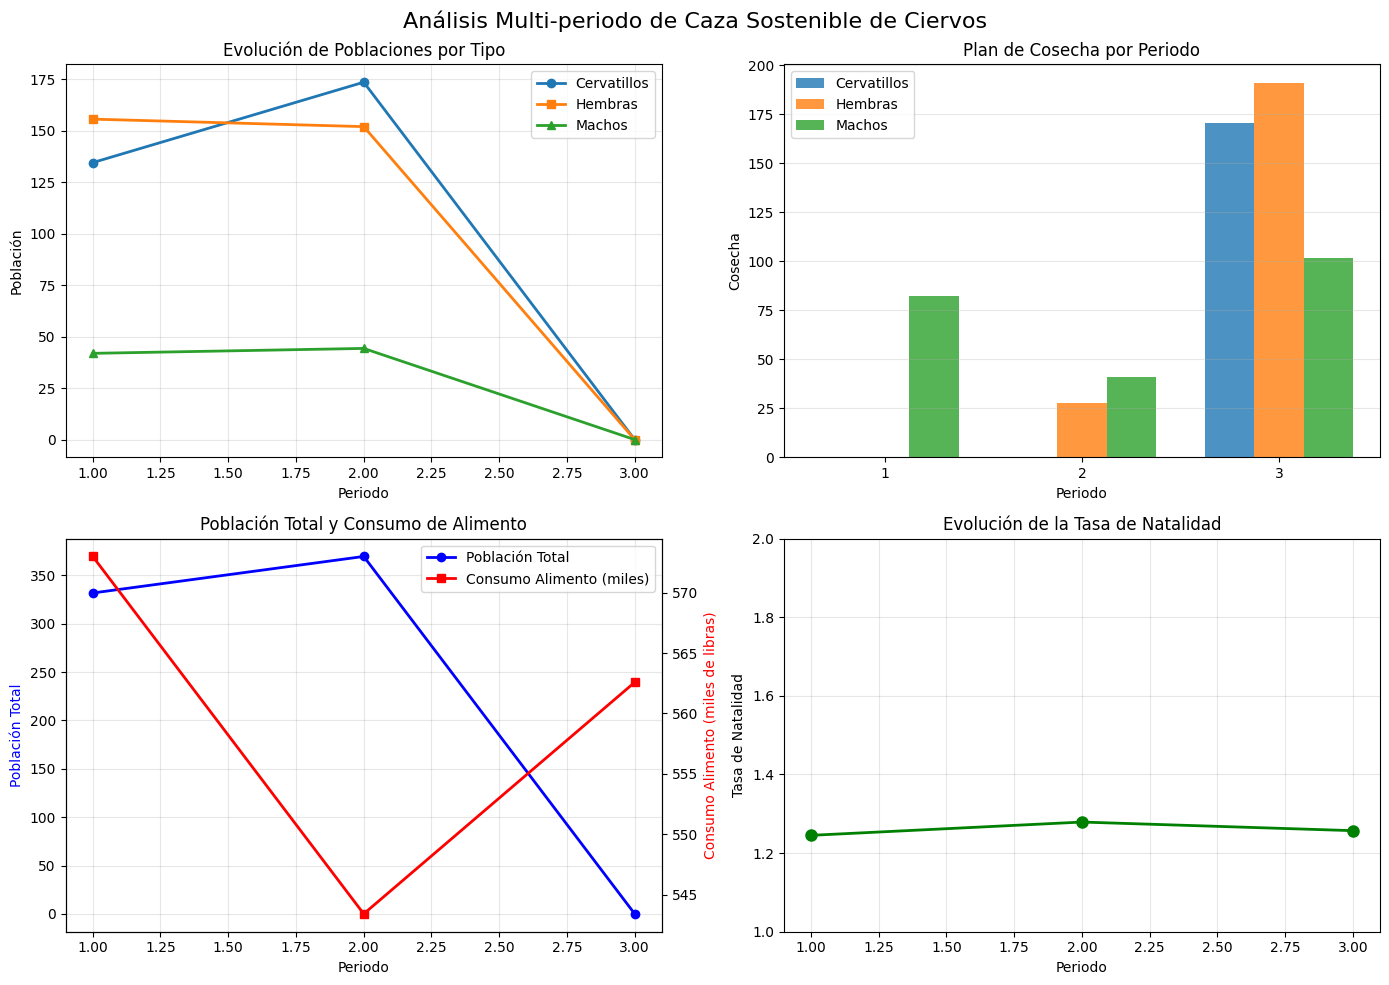


📊 Visualizaciones generadas exitosamente


In [7]:
# ============================================
# CELDA 7: Visualización de resultados (opcional)
# ============================================

import matplotlib.pyplot as plt

if 'df_resultados' in locals():
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Análisis Multi-periodo de Caza Sostenible de Ciervos', fontsize=16)

    # 1. Evolución de poblaciones
    ax1 = axes[0, 0]
    periodos = df_resultados['Periodo']
    ax1.plot(periodos, df_resultados['F_final'], 'o-', label='Cervatillos', linewidth=2)
    ax1.plot(periodos, df_resultados['D_final'], 's-', label='Hembras', linewidth=2)
    ax1.plot(periodos, df_resultados['B_final'], '^-', label='Machos', linewidth=2)
    ax1.set_xlabel('Periodo')
    ax1.set_ylabel('Población')
    ax1.set_title('Evolución de Poblaciones por Tipo')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Plan de cosecha
    ax2 = axes[0, 1]
    width = 0.25
    x = np.arange(len(periodos))
    ax2.bar(x - width, df_resultados['Cosecha_F'], width, label='Cervatillos', alpha=0.8)
    ax2.bar(x, df_resultados['Cosecha_D'], width, label='Hembras', alpha=0.8)
    ax2.bar(x + width, df_resultados['Cosecha_B'], width, label='Machos', alpha=0.8)
    ax2.set_xlabel('Periodo')
    ax2.set_ylabel('Cosecha')
    ax2.set_title('Plan de Cosecha por Periodo')
    ax2.set_xticks(x)
    ax2.set_xticklabels(periodos)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Población total vs Consumo de alimento
    ax3 = axes[1, 0]
    ax3_twin = ax3.twinx()
    line1 = ax3.plot(periodos, df_resultados['Poblacion_Total'], 'b-o',
                     label='Población Total', linewidth=2)
    line2 = ax3_twin.plot(periodos, df_resultados['Consumo_Alim']/1000, 'r-s',
                          label='Consumo Alimento (miles)', linewidth=2)
    ax3.set_xlabel('Periodo')
    ax3.set_ylabel('Población Total', color='b')
    ax3_twin.set_ylabel('Consumo Alimento (miles de libras)', color='r')
    ax3.set_title('Población Total y Consumo de Alimento')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='best')
    ax3.grid(True, alpha=0.3)

    # 4. Tasa de natalidad
    ax4 = axes[1, 1]
    ax4.plot(periodos, df_resultados['Tasa_Natal'], 'g-o', linewidth=2, markersize=8)
    ax4.set_xlabel('Periodo')
    ax4.set_ylabel('Tasa de Natalidad')
    ax4.set_title('Evolución de la Tasa de Natalidad')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([1.0, 2.0])

    plt.tight_layout()
    plt.show()

    print("\n📊 Visualizaciones generadas exitosamente")

In [8]:
# ============================================
# CELDA 8: Exportar modelo a archivo .py
# ============================================

# Generar archivo Python con el modelo
codigo_modelo = '''# DeerHarvesting_MultiPeriod.py
"""
Modelo Multi-periodo de Caza Sostenible de Ciervos usando Blocks de Pyomo
Autor: [Tu nombre]
Fecha: 2024
"""

import pyomo.environ as pyo
import numpy as np

def crear_modelo_deer_multiperiodo(num_periodos=3):
    """
    Crea un modelo multi-periodo de caza sostenible de ciervos.
    """

    # Parámetros del modelo (Bailey, 1984)
    params = {
        'p1': 0.88, 'p2': 0.82, 'p3': 0.92,
        'p4': 0.84, 'p5': 0.73, 'p6': 0.87,
        'p7': 2700, 'p8': 2300, 'p9': 540,
        'ps': 700000,
        'wf': 1.0, 'wd': 1.0, 'wb': 10.0
    }

    model = pyo.ConcreteModel(name="DeerHarvesting_MultiPeriod")
    model.PERIODOS = pyo.RangeSet(1, num_periodos)

    # Asignar parámetros
    for key, value in params.items():
        setattr(model, key, value)

    # Población inicial
    model.f0, model.d0, model.b0 = 150, 120, 80

    def periodo_rule(bloque, t):
        # Variables del periodo
        bloque.f = pyo.Var(bounds=(0, 500), initialize=100)
        bloque.d = pyo.Var(bounds=(0, 500), initialize=100)
        bloque.b = pyo.Var(bounds=(0, 500), initialize=80)
        bloque.hf = pyo.Var(bounds=(0, 200), initialize=10)
        bloque.hd = pyo.Var(bounds=(0, 200), initialize=10)
        bloque.hb = pyo.Var(bounds=(0, 200), initialize=10)
        bloque.br = pyo.Var(bounds=(1.1, 1.9), initialize=1.5)
        bloque.c = pyo.Var(bounds=(0, 800000), initialize=500000)
        bloque.f_inicial = pyo.Var(bounds=(0, 500), initialize=100)
        bloque.d_inicial = pyo.Var(bounds=(0, 500), initialize=100)
        bloque.b_inicial = pyo.Var(bounds=(0, 500), initialize=80)

        # Restricciones
        m = bloque.model()

        bloque.f_balance = pyo.Constraint(
            expr=bloque.f == m.p1*bloque.br*(m.p2/10*bloque.f_inicial +
                 m.p3*bloque.d_inicial) - bloque.hf)

        bloque.d_balance = pyo.Constraint(
            expr=bloque.d == m.p4*bloque.d_inicial +
                 m.p5/2*bloque.f_inicial - bloque.hd)

        bloque.b_balance = pyo.Constraint(
            expr=bloque.b == m.p6*bloque.b_inicial +
                 m.p5/2*bloque.f_inicial - bloque.hb)

        bloque.food_cons = pyo.Constraint(
            expr=bloque.c == m.p7*bloque.b_inicial +
                 m.p8*bloque.d_inicial + m.p9*bloque.f_inicial)

        bloque.supply = pyo.Constraint(expr=bloque.c <= m.ps)

        bloque.birth_rate = pyo.Constraint(
            expr=bloque.br == 1.1 + 0.8*(m.ps - bloque.c)/m.ps)

        bloque.min_buck = pyo.Constraint(
            expr=bloque.b >= 0.2*(0.4*bloque.f + bloque.d))

        return bloque

    model.periodo = pyo.Block(model.PERIODOS, rule=periodo_rule)

    # Conexiones entre periodos
    model.conexion = pyo.ConstraintList()
    for t in model.PERIODOS:
        if t == 1:
            model.conexion.add(model.periodo[t].f_inicial == model.f0)
            model.conexion.add(model.periodo[t].d_inicial == model.d0)
            model.conexion.add(model.periodo[t].b_inicial == model.b0)
        else:
            model.conexion.add(model.periodo[t].f_inicial == model.periodo[t-1].f)
            model.conexion.add(model.periodo[t].d_inicial == model.periodo[t-1].d)
            model.conexion.add(model.periodo[t].b_inicial == model.periodo[t-1].b)

    # Función objetivo
    def objetivo_rule(m):
        return sum(0.95**(t-1) * (m.wb*m.periodo[t].hb +
                   m.wd*m.periodo[t].hd + m.wf*m.periodo[t].hf)
                   for t in m.PERIODOS)

    model.objetivo = pyo.Objective(rule=objetivo_rule, sense=pyo.maximize)

    return model

if __name__ == "__main__":
    # Crear y resolver modelo
    model = crear_modelo_deer_multiperiodo(3)

    # Resolver
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    # Mostrar resultados
    print("\\nResultados del modelo multi-periodo:")
    for t in model.PERIODOS:
        print(f"\\nPeriodo {t}:")
        print(f"  Poblaciones: F={pyo.value(model.periodo[t].f):.2f}, "
              f"D={pyo.value(model.periodo[t].d):.2f}, "
              f"B={pyo.value(model.periodo[t].b):.2f}")
        print(f"  Cosechas: HF={pyo.value(model.periodo[t].hf):.2f}, "
              f"HD={pyo.value(model.periodo[t].hd):.2f}, "
              f"HB={pyo.value(model.periodo[t].hb):.2f}")

    print(f"\\nValor objetivo: {pyo.value(model.objetivo):.2f}")
'''

# Guardar archivo
with open('DeerHarvesting_MultiPeriod.py', 'w') as f:
    f.write(codigo_modelo)

print("✅ Archivo 'DeerHarvesting_MultiPeriod.py' creado exitosamente")
print("   Puedes ejecutarlo con: python DeerHarvesting_MultiPeriod.py")

✅ Archivo 'DeerHarvesting_MultiPeriod.py' creado exitosamente
   Puedes ejecutarlo con: python DeerHarvesting_MultiPeriod.py



 ANÁLISIS DE SENSIBILIDAD

📊 Evaluando diferentes niveles de suministro de alimento...
------------------------------------------------------------
Probando con suministro: 500,000 libras... ✅ Modelo multi-periodo creado con 3 periodos
   - Variables por periodo: 8
   - Restricciones por periodo: 7
   - Total variables: 24
   - Total restricciones: 30


  - termination condition: infeasible
  - message from solver: Ipopt 3.14.19\x3a Converged to a locally infeasible point. Problem may be infeasible.


❌ Infactible (suministro insuficiente)
Probando con suministro: 600,000 libras... ✅ Modelo multi-periodo creado con 3 periodos
   - Variables por periodo: 8
   - Restricciones por periodo: 7
   - Total variables: 24
   - Total restricciones: 30
✅ Resuelto
Probando con suministro: 700,000 libras... ✅ Modelo multi-periodo creado con 3 periodos
   - Variables por periodo: 8
   - Restricciones por periodo: 7
   - Total variables: 24
   - Total restricciones: 30
✅ Resuelto
Probando con suministro: 800,000 libras... ✅ Modelo multi-periodo creado con 3 periodos
   - Variables por periodo: 8
   - Restricciones por periodo: 7
   - Total variables: 24
   - Total restricciones: 30
✅ Resuelto
Probando con suministro: 900,000 libras... ✅ Modelo multi-periodo creado con 3 periodos
   - Variables por periodo: 8
   - Restricciones por periodo: 7
   - Total variables: 24
   - Total restricciones: 30
✅ Resuelto

 RESULTADOS DEL ANÁLISIS DE SENSIBILIDAD

  Suministro |     Estado |    Valor Obj | Pob. Fi

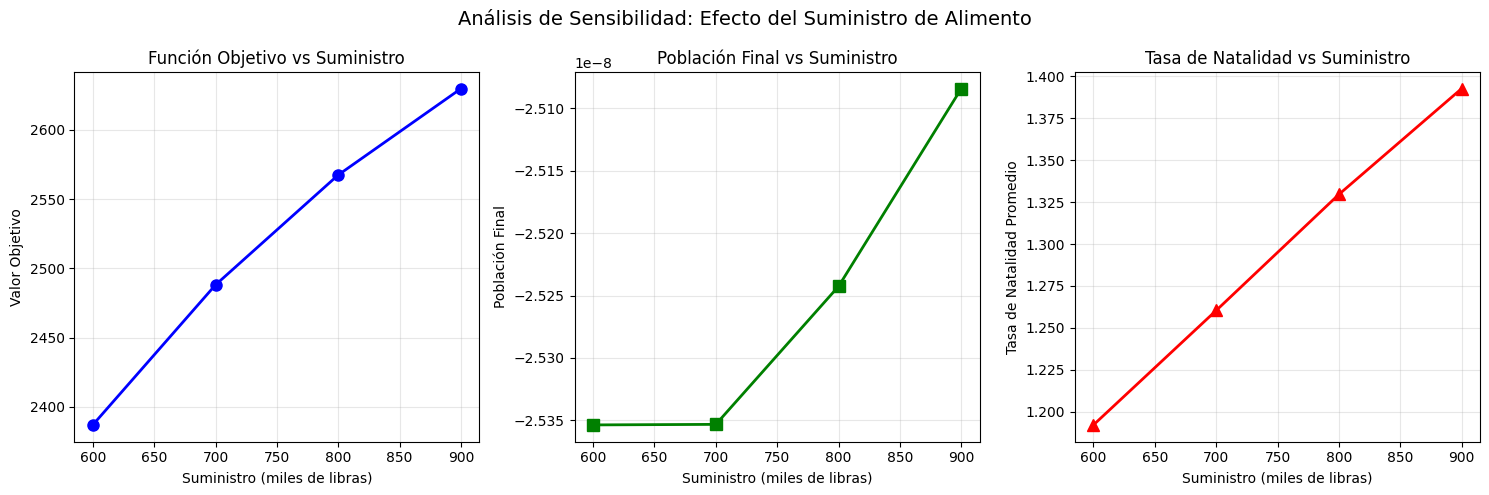


📊 Gráficos de sensibilidad generados exitosamente

 ANÁLISIS DE SENSIBILIDAD COMPLETO


In [10]:
# ============================================
# CELDA 9: Análisis de sensibilidad (CORREGIDA)
# ============================================

print("\n" + "="*60)
print(" ANÁLISIS DE SENSIBILIDAD")
print("="*60)

# Importar lo necesario
from pyomo.opt import TerminationCondition
import warnings
warnings.filterwarnings('ignore')

# Experimento: Variar el suministro de alimento
suministros = [500000, 600000, 700000, 800000, 900000]
resultados_sensibilidad = []

print("\n📊 Evaluando diferentes niveles de suministro de alimento...")
print("-" * 60)

for ps_test in suministros:
    print(f"Probando con suministro: {ps_test:,} libras...", end=" ")

    # Crear nuevo modelo con diferente suministro
    params_test = PARAMS.copy()
    params_test['ps'] = ps_test

    try:
        model_test = crear_modelo_multiperiodo(NUM_PERIODOS, params_test)

        # Resolver silenciosamente
        solver_test = pyo.SolverFactory('ipopt')
        solver_test.options['print_level'] = 0
        solver_test.options['max_iter'] = 3000
        results_test = solver_test.solve(model_test, tee=False)

        # Verificar si la solución es óptima o al menos factible
        if (results_test.solver.termination_condition == TerminationCondition.optimal or
            results_test.solver.termination_condition == TerminationCondition.feasible):

            # Calcular valor objetivo
            valor_obj = pyo.value(model_test.objetivo)

            # Calcular población final (CORRECCIÓN DEL ERROR)
            pob_final = (pyo.value(model_test.periodo[NUM_PERIODOS].f) +
                        pyo.value(model_test.periodo[NUM_PERIODOS].d) +
                        pyo.value(model_test.periodo[NUM_PERIODOS].b))

            # Calcular cosecha total
            cosecha_total = 0
            for t in model_test.PERIODOS:
                cosecha_total += (pyo.value(model_test.periodo[t].hf) +
                                pyo.value(model_test.periodo[t].hd) +
                                pyo.value(model_test.periodo[t].hb))

            # Calcular tasa de natalidad promedio
            br_promedio = sum(pyo.value(model_test.periodo[t].br)
                            for t in model_test.PERIODOS) / NUM_PERIODOS

            resultados_sensibilidad.append({
                'Suministro': ps_test,
                'Valor_Objetivo': valor_obj,
                'Poblacion_Final': pob_final,
                'Cosecha_Total': cosecha_total,
                'Tasa_Natal_Prom': br_promedio,
                'Estado': 'Óptimo' if results_test.solver.termination_condition == TerminationCondition.optimal else 'Factible'
            })
            print("✅ Resuelto")

        elif results_test.solver.termination_condition == TerminationCondition.infeasible:
            print("❌ Infactible (suministro insuficiente)")
            resultados_sensibilidad.append({
                'Suministro': ps_test,
                'Valor_Objetivo': None,
                'Poblacion_Final': None,
                'Cosecha_Total': None,
                'Tasa_Natal_Prom': None,
                'Estado': 'Infactible'
            })
        else:
            print(f"⚠️ {results_test.solver.termination_condition}")

    except Exception as e:
        print(f"❌ Error: {str(e)[:30]}")
        continue

# Mostrar resultados del análisis de sensibilidad
if resultados_sensibilidad:
    print("\n" + "="*80)
    print(" RESULTADOS DEL ANÁLISIS DE SENSIBILIDAD")
    print("="*80)

    # Crear tabla de resultados
    print(f"\n{'Suministro':>12} | {'Estado':>10} | {'Valor Obj':>12} | {'Pob. Final':>10} | {'Cosecha':>10} | {'Tasa Natal':>10}")
    print("-" * 80)

    for r in resultados_sensibilidad:
        if r['Valor_Objetivo'] is not None:
            print(f"{r['Suministro']:12,} | {r['Estado']:>10} | {r['Valor_Objetivo']:12.2f} | "
                  f"{r['Poblacion_Final']:10.1f} | {r['Cosecha_Total']:10.1f} | {r['Tasa_Natal_Prom']:10.3f}")
        else:
            print(f"{r['Suministro']:12,} | {r['Estado']:>10} | {'---':>12} | "
                  f"{'---':>10} | {'---':>10} | {'---':>10}")

    # Análisis de tendencias
    resultados_validos = [r for r in resultados_sensibilidad if r['Valor_Objetivo'] is not None]

    if len(resultados_validos) >= 2:
        print("\n" + "="*80)
        print(" ANÁLISIS DE TENDENCIAS")
        print("="*80)

        # Calcular cambios porcentuales
        suministro_base = resultados_validos[0]['Suministro']
        valor_base = resultados_validos[0]['Valor_Objetivo']

        print(f"\n📈 Cambios relativos al suministro base ({suministro_base:,} libras):")
        print("-" * 60)

        for r in resultados_validos[1:]:
            cambio_suministro = ((r['Suministro'] - suministro_base) / suministro_base) * 100
            cambio_objetivo = ((r['Valor_Objetivo'] - valor_base) / valor_base) * 100 if valor_base > 0 else 0
            cambio_poblacion = ((r['Poblacion_Final'] - resultados_validos[0]['Poblacion_Final']) /
                              resultados_validos[0]['Poblacion_Final']) * 100 if resultados_validos[0]['Poblacion_Final'] > 0 else 0

            print(f"Suministro {r['Suministro']:,} ({cambio_suministro:+.1f}%):")
            print(f"  → Objetivo: {cambio_objetivo:+.1f}%")
            print(f"  → Población: {cambio_poblacion:+.1f}%")
            print(f"  → Tasa natal: {r['Tasa_Natal_Prom']:.3f}")

    # Visualización opcional
    try:
        import matplotlib.pyplot as plt

        if len(resultados_validos) >= 2:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle('Análisis de Sensibilidad: Efecto del Suministro de Alimento', fontsize=14)

            suministros_validos = [r['Suministro']/1000 for r in resultados_validos]

            # Gráfico 1: Valor objetivo
            ax1 = axes[0]
            valores_obj = [r['Valor_Objetivo'] for r in resultados_validos]
            ax1.plot(suministros_validos, valores_obj, 'o-', color='blue', linewidth=2, markersize=8)
            ax1.set_xlabel('Suministro (miles de libras)')
            ax1.set_ylabel('Valor Objetivo')
            ax1.set_title('Función Objetivo vs Suministro')
            ax1.grid(True, alpha=0.3)

            # Gráfico 2: Población final
            ax2 = axes[1]
            poblaciones = [r['Poblacion_Final'] for r in resultados_validos]
            ax2.plot(suministros_validos, poblaciones, 's-', color='green', linewidth=2, markersize=8)
            ax2.set_xlabel('Suministro (miles de libras)')
            ax2.set_ylabel('Población Final')
            ax2.set_title('Población Final vs Suministro')
            ax2.grid(True, alpha=0.3)

            # Gráfico 3: Tasa de natalidad
            ax3 = axes[2]
            tasas = [r['Tasa_Natal_Prom'] for r in resultados_validos]
            ax3.plot(suministros_validos, tasas, '^-', color='red', linewidth=2, markersize=8)
            ax3.set_xlabel('Suministro (miles de libras)')
            ax3.set_ylabel('Tasa de Natalidad Promedio')
            ax3.set_title('Tasa de Natalidad vs Suministro')
            ax3.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            print("\n📊 Gráficos de sensibilidad generados exitosamente")

    except ImportError:
        print("\n⚠️ matplotlib no disponible para visualización")
    except Exception as e:
        print(f"\n⚠️ Error al generar gráficos: {e}")

else:
    print("\n❌ No se pudieron obtener resultados del análisis de sensibilidad")

print("\n" + "="*60)
print(" ANÁLISIS DE SENSIBILIDAD COMPLETO")
print("="*60)